In [24]:
import numpy as np
import os 
from pathlib import Path
from typing import List, Dict, Union
import glob
from matplotlib.patches import Polygon

PathLike = Union[Path, str]
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataset import get_paths, PathLike, is_image
from pycocotools.coco import COCO
import pandas as pd
import json
from dataset.preprossesing import resize_images
from PIL import Image

In [ ]:

resize_images(['../../dataset/segmentation/test/'], ['bmp'],'../../dataset/segmentation/test/', (1024,1024),{'dtype': int})

In [26]:
test_image = list(filter( lambda x: True if is_image(x) else False, get_paths('../../dataset/segmentation/test/')))
for f in test_image:
    print(f)
    image = Image.open(f)
    image = image.convert('RGB')
    image.save(f.replace('bmp','jpg'))

../../dataset/segmentation/test/ManualGeneralImage_11_12_19.jpg
../../dataset/segmentation/test/ManualGeneralImage_10_30_16.jpg
../../dataset/segmentation/test/zoomed_Full_637437073345787769.jpg
../../dataset/segmentation/test/zoomed_Full_637437067296374854.jpg
../../dataset/segmentation/test/ManualGeneralImage_10_11_29.jpg
../../dataset/segmentation/test/zoomed_Full_637437067053998640.jpg
../../dataset/segmentation/test/ManualGeneralImage_11_12_49.jpg
../../dataset/segmentation/test/ManualGeneralImage_10_11_38.jpg
../../dataset/segmentation/test/zoomed_Full_637437106555222339.jpg
../../dataset/segmentation/test/zoomed_Full_637437072277634535.jpg
../../dataset/segmentation/test/zoomed_ManualDetailedImage_10_03_00.jpg
../../dataset/segmentation/test/zoomed_Full_637437106067970531.jpg
../../dataset/segmentation/test/ManualGeneralImage_10_12_05.jpg
../../dataset/segmentation/test/zoomed_Full_637437074505417632.jpg
../../dataset/segmentation/test/ManualGeneralImage_10_12_12.jpg
../../datas

In [27]:
list_path_to_annotations = list(filter( lambda x: True if x.split('.')[-1] == 'json' else False, get_paths('../../dataset/annotation/')))
len(list_path_to_annotations)
list_path_to_annotations

['../../dataset/annotation/pits_stones_detections_300920/instances_default.json',
 '../../dataset/annotation/asbestos_stone_161220/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_020221/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161120/instances_default.json',
 '../../dataset/annotation/open-pit-zoomed-161120/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161220/instances_default.json',
 '../../dataset/annotation/test transport/annotations/instances_default.json',
 '../../dataset/annotation/asbestos_stone_020221/instances_default.json',
 '../../dataset/annotation/asbest_stones_111121/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_111121/instances_default.json']

In [28]:
coco = COCO(list_path_to_annotations[4])
print(len(coco.anns), len(coco.imgs))
image_names = coco.imgs

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
245 24


In [29]:
frame = pd.DataFrame({d['id']: d for d in json.load(open(list_path_to_annotations[4],'r'))['annotations']}).T
frame

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
1,1,1,1,"[[2151.8, 1826.33, 2175.61, 1788.4, 2217.07, 1...",280882.0,"[1791.93, 1092.47, 525.69, 747.09]",0,{'occluded': False}
2,2,1,1,"[[330.31, 1508.52, 341.2, 1523.92, 355.1, 1535...",24249.0,"[221.27, 1494.06, 185.29, 227.74]",0,{'occluded': False}
3,3,1,1,"[[2149.99, 2045.91, 2151.01, 2024.98, 2152.54,...",63857.0,"[2149.99, 1852.96, 442.01, 195.04]",0,{'occluded': False}
4,4,1,1,"[[1507.75, 1547.72, 1536.99, 1533.54, 1576.87,...",14812.0,"[1473.48, 1389.68, 131.16, 161.58]",0,{'occluded': False}
5,5,1,1,"[[1337.73, 988.88, 1348.18, 1022.3, 1212.39, 1...",52297.0,"[1061.99, 951.28, 286.19, 371.83]",0,{'occluded': False}
...,...,...,...,...,...,...,...,...
241,241,24,1,"[[829.91, 1449.05, 956.33, 1556.51, 877.32, 16...",79599.0,"[596.03, 1404.8, 360.3, 347.66]",0,{'occluded': False}
242,242,24,1,"[[1026.24, 179.24, 1042.77, 166.09, 1052.53, 1...",109380.0,"[776.6, 130.41, 427.68, 469.89]",0,{'occluded': False}
243,243,24,1,"[[1860.0, 2048.0, 1817.63, 1994.91, 1834.56, 1...",67480.0,"[1817.63, 1812.86, 494.29, 235.14]",0,{'occluded': False}
244,244,24,1,"[[1429.41, 1132.17, 1459.4, 1100.41, 1493.8, 1...",581389.0,"[929.3, 266.89, 1099.01, 868.8]",0,{'occluded': False}


In [ ]:
from typing import List, Union

def image_segmentation_from_frame(frame: pd.DataFrame, img_id: int, category_id:int, images):
    maska = (frame.image_id == img_id) & (frame.category_id == category_id)
    h_img = images[img_id]['height']
    w_img = images[img_id]['width']
    return [{category_id: normalize_segment(np.array(list(s[0])), h_img, w_img)} for s in frame[maska].segmentation]

def normalize_segment(segment, h_img, w_img):
    segment[::2] /=w_img
    segment[1::2]/=h_img
    return segment

p
            
img_id = 13
s = image_segmentation_from_frame(frame, img_id, 1, image_names)
save_segmentation(s,image_names[img_id]['file_name'].split('.')[-2] + '.txt')

In [332]:
out_path = Path('/home/kirilman/Project/dataset/segmentation/seg/')

In [ ]:
for k, v in image_names.items():
    if isinstance(v, dict):
        img_id = v['id']
        segments = image_segmentation_from_frame(frame, img_id, 1,image_names)
        filename = out_path \ v['file_name'].split('.')[-2] + '.txt'
        save_segmentation(segments, filename)

In [ ]:
arr_segment = np.array(segments[0][1])
arr_segment[::2] = arr_segment[::2]/

In [ ]:
count_images = 0
for path_2_anno in list_path_to_annotations:
    coco = COCO(path_2_anno)
    count_images+=len(coco.imgs)
    print(len(coco.anns), len(coco.imgs))
    image_names = coco.imgs
    for k, image in image_names.items():
        if isinstance(image, dict):
            img_id = image['id']
            segments = image_segmentation_from_frame(frame, img_id, 1,image_names)
            filename = str(out_path / image['file_name'].split('/')[-1].split('.')[-2]) + '.txt'
            # save_segmentation(segments, filename)
            print(path_2_anno + image['file_name'])

In [335]:
sys.path.append('/home/kirilman/Project/asbestos/dataset')
from dataset import is_image
from dataset.processor import JsonSegmentProcessing
import shutil

In [343]:
!rm -r /home/kirilman/Project/dataset/segmentation/seg/*.txt

In [344]:
list_path_to_annotations

['../../dataset/annotation/pits_stones_detections_300920/instances_default.json',
 '../../dataset/annotation/asbestos_stone_161220/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_020221/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161120/instances_default.json',
 '../../dataset/annotation/open-pit-zoomed-161120/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161220/instances_default.json',
 '../../dataset/annotation/test transport/annotations/instances_default.json',
 '../../dataset/annotation/asbestos_stone_020221/instances_default.json',
 '../../dataset/annotation/asbest_stones_111121/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_111121/instances_default.json']

In [345]:
s = 0
unused = ['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json', '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']
for p in list_path_to_annotations:
    if p in unused:
        print(p)
        continue
    proccesor = JsonSegmentProcessing(p, 1, '/home/kirilman/Project/dataset/segmentation/seg/')
    proccesor.process() 

../../dataset/annotation/open-pit-zoomed-161120/instances_default.json
../../dataset/annotation/pits_stones_detections_161220/instances_default.json


In [30]:
print('Количество меток:', 
len(list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, os.listdir('/home/kirilman/Project/dataset/segmentation/seg/')))) )

Количество меток: 394


In [363]:
print(unused)
for p in unused:
    proccesor = JsonSegmentProcessing(p,
                                  1, '/home/kirilman/Project/dataset/segmentation/test/')
    proccesor.process()

['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json', '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']


In [361]:
image_files = list(filter( lambda x: True if x.split('.')[-1] != 'txt' else False, get_paths('../../dataset/segmentation/seg/')))
label_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/seg/')))
images = {}
for image_file in image_files:
    for label in label_files:
        if image_file.split('.')[-2] in label:
            images[label] = image_file
len(images)

350

In [362]:
root_path = Path('/home/kirilman/Project/dataset/segmentation/')
count = len(label_files)
print(count, count*0.1)
val_index = np.random.choice(label_files,35)

for f_label, f_image in images.items():
    if f_label in val_index:
        shutil.copy(f_label, root_path / 'val' / Path(f_label).name)
        shutil.copy(f_image, root_path / 'val' / Path(f_image).name)
    else:
        shutil.copy(f_label, root_path / 'train' / Path(f_label).name)
        shutil.copy(f_image, root_path / 'train' / Path(f_image).name)

350 35.0


In [ ]:
for root in unused:
    for f in os.listdir(Path(root).parent):
        save_path = Path('/home/kirilman/Project/dataset/segmentation/test') / f.name
        shutil.copy(Path(root) + Path(f).name, save_path)

In [383]:
unused

['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']

In [7]:
from dataset.preprossesing import resize_images
import cv2

### Merge annotation from train and prediction-segment

In [325]:
train_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/merge/train/')))
predict_file = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../yolov5/runs/predict-seg/exp4/labels')))
print(len(train_files), len(predict_file))

318 318


In [286]:
train_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/merge/val/')))
predict_file = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../yolov5/runs/predict-seg/exp5/')))
print(len(train_files), len(predict_file))

32 32


In [326]:
labels = []
for train, pred in zip(train_files, predict_file):
    # print(train, pred)
    with open(train, 'a') as f_train:
        with open(pred, 'r') as f_pred:
            labels = f_pred.readlines()
            for label in labels:
                arr_label = np.fromstring(label, sep = ' ')
                arr_label[1:] = arr_label[1:]/1024
        
                f_train.write(to_string(arr_label))
                            

43


(0.0, 1.0)

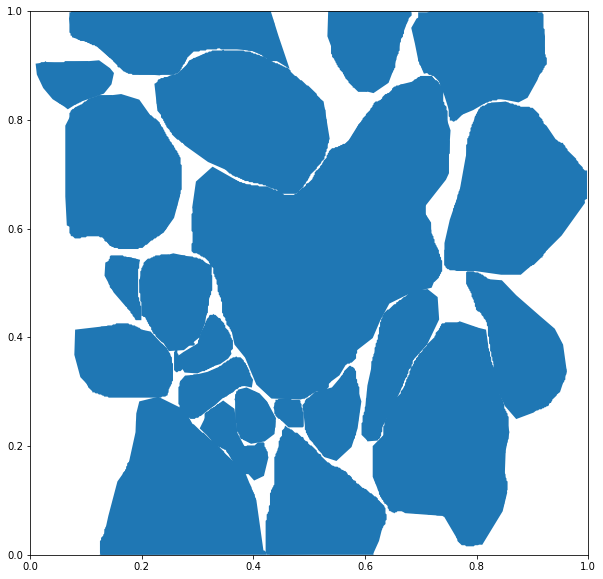

In [280]:
with open('../../dataset/segmentation/merge/1_12_09_40_05-03-2020_1.txt', 'r') as f:
    labels = f.readlines()
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# polygon1 = Polygon([(0,1), (1,1), (3,0),])

fig, ax = plt.subplots(1,1, figsize = (10,10))
for i,label in enumerate(labels):
    label = np.fromstring(label, sep=' ')[1:]
    polygon1 = Polygon([(x,y) for x,y in zip(label[0::2],label[1::2])])
    polygon1
    ax.add_patch(polygon1)
print(i)   
plt.ylim(0,1)
plt.xlim(0,1)

(0.0, 1.0)

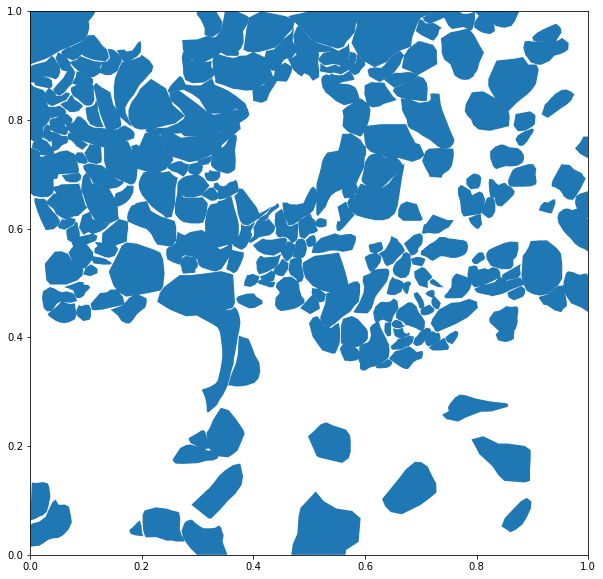

In [19]:
with open('../yolov5/runs/predict-seg/exp4/labels/637412006957367334.txt', 'r') as f:
    labels = f.readlines()

with open('/home/kirilman/Project/dataset/segmentation/small/train/ManualGeneralImage_13_56_14.txt', 'r') as f:
    labels = f.readlines()
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# polygon1 = Polygon([(0,1), (1,1), (3,0),])

fig, ax = plt.subplots(1,1, figsize = (10,10))
for i,label in enumerate(labels):
    label = np.fromstring(label, sep=' ')[1:]
    polygon1 = Polygon([(x,y) for x,y in zip(label[0::2],label[1::2])])
    area = sPolygon([(x,y) for x,y in zip(label[0::2],label[1::2])]).area
    ax.add_patch(polygon1)

    # if area > 0.005:
        # ax.add_patch(polygon1)
    # if area > 0.00:
    #     ax.add_patch(polygon1)  
plt.ylim(0,1)
plt.xlim(0,1)
# labels

### Segmentation filter, squre analyse

In [6]:
from shapely.geometry import Polygon as sPolygon
from dataset.path_utils import get_paths_from_dirs
from dataset.processor import SegmentSquareFilter
# !pip install shapely
sPolygon([(0,0),(2,0),(1,1), (0,2)]).area

2.0

9487 0.01745830167228839 0.004327205
8678


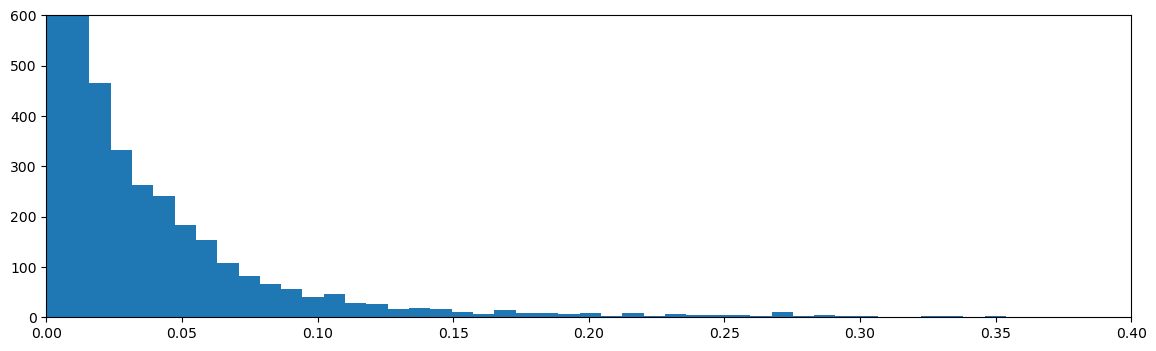

In [15]:
def read_segmentation_labels(p: PathLike):
    with open(p, 'r') as f:
        lines = f.readlines()
        return [np.fromstring(line, sep=' ') for line in lines]

files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
areas = []

for f in files:
    labels = read_segmentation_labels(f)
    for label in labels:
        mask = label[1:]
        p = sPolygon([(x,y) for x,y in zip(mask[0::2], mask[1::2])] )
        areas+=[p.area]
areas = np.array(areas)

print(len(areas), areas.mean(), np.median(areas))
fig = plt.figure(figsize=(14,4),dpi = 100)
plt.hist(areas,60);
plt.ylim(0,600)
plt.xlim(0.00,0.4)
print(len(np.where(areas>0.001)[0]))

In [16]:
files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/train/', 0.005)
    seg.process()

In [31]:
files = get_paths_from_dirs(['../../dataset/segmentation/val/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/val/', 0.005)
    seg.process()

In [6]:
files = get_paths_from_dirs(['../../dataset/segmentation/test/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/test', 0.005, True)
    seg.process()

In [32]:
## small object

In [16]:
files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/train/', 0.01, False)
    seg.process()

In [17]:
files = get_paths_from_dirs(['../../dataset/segmentation/val/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/val/', 0.01, False)
    seg.process()

In [7]:
files = get_paths_from_dirs(['../../dataset/segmentation/test/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/test/', 0.01, False)
    seg.process()

In [2]:
0.01*1024

10.24